In [14]:
import pandas as pd
import torch
import torch.nn as nn
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [16]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [18]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [20]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)
        seq_length = tgt.size(-1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, 1, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [21]:
df = pd.read_csv('a_catalog.csv')
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.expand_frame_repr', False)

In [22]:
df.drop('name_s', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df.drop('nuniverse', axis=1, inplace=True)

scaler_number = 20000
scaler = MinMaxScaler(feature_range=(0, scaler_number))
columns_to_scale = [col for col in df.columns if col != 'stype']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [23]:
data = pd.get_dummies(df, columns=['stype']).astype(int)
data.reset_index(drop=True, inplace=True)

min_max_df = pd.DataFrame({
    'Min': data.min(),
    'Max': data.max()
}).transpose()

# If you want to preserve the original column order
min_max_df = min_max_df[data.columns]
# print(min_max_df)

flag = np.random.randint(0, 2, size=data.shape[0])

In [31]:
encoded_data_train, remaining_data_test, flag_train, remaining_flag_test = train_test_split(
    data, flag, train_size=0.7, random_state=42)

encoded_data_test, encoded_data_val, flag_test, flag_val = train_test_split(
    remaining_data_test, remaining_flag_test, test_size=0.5, random_state=42)

encoded_data_train = torch.tensor(encoded_data_train.to_numpy(), dtype=torch.long)
flag_train = torch.tensor(flag_train, dtype=torch.long)

encoded_data_test = torch.tensor(encoded_data_test.to_numpy(), dtype=torch.long)
flag_test = torch.tensor(flag_test, dtype=torch.long)

encoded_data_val = torch.tensor(encoded_data_val.to_numpy(), dtype=torch.long)
flag_val = torch.tensor(flag_val, dtype=torch.long)

In [32]:
src_vocab_size = scaler_number + 1
tgt_vocab_size = 2
d_model = 128
num_heads = 1
num_layers = 2
d_ff = 32
max_seq_length = 48
dropout = 0.1
epoch_num = 30

In [33]:
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

train_losses = []
val_losses = []
test_losses = []

In [34]:
transformer.train()
for epoch in range(epoch_num):
    optimizer.zero_grad()
    output = transformer(encoded_data_train, flag_train.unsqueeze(1))
    flag_train_dim = torch.cat((1 - flag_train.view(-1, 1), flag_train.view(-1, 1)), dim=1)
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), flag_train_dim.float())
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

    if (epoch + 1) % 10 == 0:
        transformer.eval()
        with torch.no_grad():
            val_output = transformer(encoded_data_val, flag_val.unsqueeze(1))
            val_flag_dim = torch.cat((1 - flag_val.view(-1, 1), flag_val.view(-1, 1)), dim=1)
            val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_flag_dim.float())
            val_losses.append(val_loss.item())
            print(f"Validation Loss: {val_loss.item()}")

        transformer.train()

Epoch: 1, Loss: 0.7821056246757507
Epoch: 2, Loss: 0.7450225353240967
Epoch: 3, Loss: 0.7077308893203735
Epoch: 4, Loss: 0.676039457321167
Epoch: 5, Loss: 0.6415907740592957
Epoch: 6, Loss: 0.6117668151855469
Epoch: 7, Loss: 0.5819569230079651
Epoch: 8, Loss: 0.5535251498222351
Epoch: 9, Loss: 0.5245060920715332
Epoch: 10, Loss: 0.4973253607749939
Validation Loss: 0.4434053897857666
Epoch: 11, Loss: 0.4722684323787689
Epoch: 12, Loss: 0.4464811086654663
Epoch: 13, Loss: 0.42204704880714417
Epoch: 14, Loss: 0.3983762860298157
Epoch: 15, Loss: 0.37637045979499817
Epoch: 16, Loss: 0.3552122116088867
Epoch: 17, Loss: 0.33312052488327026
Epoch: 18, Loss: 0.3127477169036865
Epoch: 19, Loss: 0.2941333055496216
Epoch: 20, Loss: 0.2744104862213135
Validation Loss: 0.2225174903869629
Epoch: 21, Loss: 0.25751686096191406
Epoch: 22, Loss: 0.24119068682193756
Epoch: 23, Loss: 0.2256307452917099
Epoch: 24, Loss: 0.21008311212062836
Epoch: 25, Loss: 0.19622941315174103
Epoch: 26, Loss: 0.182033166289

In [112]:
transformer.eval()
with torch.no_grad():
    test_output = transformer(encoded_data_test, flag_test.unsqueeze(1))
    test_flag_dim = torch.cat((1 - flag_test.view(-1, 1), flag_test.view(-1, 1)), dim=1)
    test_loss = criterion(test_output.contiguous().view(-1, tgt_vocab_size), test_flag_dim.float())
    test_losses.append(test_loss.item())
    print(f"Testing Loss: {test_loss.item()}")

Testing Loss: 0.09800751507282257


In [109]:
import numpy as np
import pandas as pd

# Seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 1000

# Generate artificial data
masses = np.random.uniform(0.1, 10.0, n_samples)  # Earth masses
radii = np.random.uniform(0.5, 2.5, n_samples)  # Earth radii
eccentricities = np.random.uniform(0, 0.9, n_samples)
semi_major_axes = np.random.uniform(0.1, 5.0, n_samples)  # AU
surface_temperatures = np.random.uniform(200, 350, n_samples)  # Kelvin

habitability = (
    (masses >= 0.5) & (masses <= 5.0) &
    (radii >= 0.8) & (radii <= 1.5) &
    (eccentricities < 0.5) &
    (semi_major_axes >= 0.5) & (semi_major_axes <= 2.5) &
    (surface_temperatures >= 250) & (surface_temperatures <= 320)
).astype(int)  # Convert boolean to int (0 or 1)

# Create a DataFrame
data = pd.DataFrame({
    'Mass': masses,
    'Radius': radii,
    'Eccentricity': eccentricities,
    'Semi_major_axis': semi_major_axes,
    'Surface_temperature': surface_temperatures,
    'Habitability': habitability
})

# Show the first few rows of the dataset
print(data.head())

# Save the dataset to a CSV file

# Define the header
header = "Mass,Radius,Eccentricity,Semi_major_axis,Surface_temperature,Habitability"


# Append the numerical data to the same file
with open('data.csv', 'a') as file:
    np.savetxt(file, data, delimiter=',', fmt='%.18e')

data=data.to_numpy()

       Mass    Radius  Eccentricity  Semi_major_axis  Surface_temperature  Habitability
0  3.807947  0.870266      0.235535         3.396245           285.799382             0
1  9.512072  1.583802      0.222281         4.003739           320.814849             0
2  7.346740  2.245892      0.815629         1.327293           314.024139             0
3  6.026719  1.964450      0.224592         3.161883           223.084986             0
4  1.644585  2.113122      0.244755         2.901555           222.387420             0


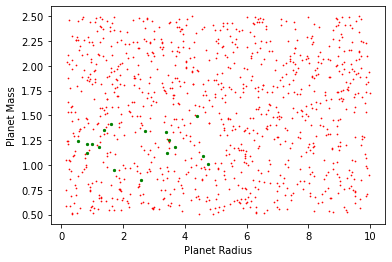

In [107]:
for i in range(len(data[0:,0])):
    if data[i,1]<100:
        if data[i,5]==1:
            plt.scatter(data[i,0],data[i,1],s=5,color='green')
        else:
            plt.scatter(data[i,0],data[i,1],s=0.5,color='red')
plt.xlabel("Planet Radius")
plt.ylabel("Planet Mass")
plt.show()

In [110]:
# Load the artificial data
data = pd.read_csv('data.csv')


In [111]:

# Split into features and target
X = data[['Mass', 'Radius', 'Eccentricity', 'Semi_major_axis', 'Surface_temperature']]
y = data['Habitability']

# Split into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


transformer.eval()
with torch.no_grad():
    test_output = transformer(encoded_data_test, flag_test.unsqueeze(1))
    test_flag_dim = torch.cat((1 - flag_test.view(-1, 1), flag_test.view(-1, 1)), dim=1)
    test_loss = criterion(test_output.contiguous().view(-1, tgt_vocab_size), test_flag_dim.float())
    test_losses.append(test_loss.item())
    print(f"Testing Loss: {test_loss.item()}")


Testing Loss: 0.09800751507282257
